In [1]:
import os
import gc
import sys
import glob
import numpy as np
import pandas as pd
import netCDF4 as nc
from datetime import datetime, timedelta
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
import matplotlib.ticker as mticker
from copy import deepcopy

In [2]:
# To use PLUMBER2_GPP_common_utils, change directory to where it exists
os.chdir('/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2')
from PLUMBER2_VPD_common_utils import *

# AU-Tum analysis

In [3]:
# Read quality contral file
QC_file_name  = "/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/Qle_Qh_Rnet_quality_control_all_sites.csv" 
LAI_file_name = "/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/LAI_all_sites_parallel.csv" 
Qle_file_name = "/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/Qle_all_sites.csv" 
SM03_file_name = "/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/SMtop0.3m_all_sites.csv" 
SM05_file_name = "/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/SMtop0.5m_all_sites.csv" 
SM1_file_name  = "/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/SMtop1m_all_sites.csv" 
SM05_per_file_name = '/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process2_output/SMtop0.5m_percentile_all_sites.csv'
EF_file_name  = '/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process2_output/EF_all_sites_1_day_mean.csv'

Qle_input     = pd.read_csv(Qle_file_name)
QC_input      = pd.read_csv(QC_file_name)
LAI_input     = pd.read_csv(LAI_file_name)
SM05_input    = pd.read_csv(SM05_file_name)
SM05_per_input= pd.read_csv(SM05_per_file_name)
EF_input      = pd.read_csv(EF_file_name)

SyntaxError: invalid syntax (3478043503.py, line 1)

### Processe data 

In [ ]:
site_name    = 'AU-Tum'
site_mask    = (Qle_input['site_name'] == site_name)

In [ ]:
Qle_tmp      = Qle_input[site_mask]
QC_tmp       = QC_input[site_mask]
LAI_tmp      = LAI_input[site_mask]
SM05_tmp     = SM05_input[site_mask]
SM05_per_tmp = SM05_per_input[site_mask]
EF_tmp       = EF_input[site_mask]

In [ ]:
qc_swdown_mask=(~np.isnan(QC_tmp['Qle_Qh_qc'])) & (Qle_tmp['obs_SWdown'] > 600)
Qle_in      = Qle_tmp[qc_swdown_mask]
LAI_in      = LAI_tmp[qc_swdown_mask]
SM05_in     = SM05_tmp[qc_swdown_mask]
SM05_per_in = SM05_per_tmp[qc_swdown_mask]
EF_in       = EF_tmp[qc_swdown_mask]

### Save site data 

In [ ]:
# Qle_in.to_csv(f'/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/site_test_AU-Tum/AU-Tum_Qle_masked.csv', index=True)
# LAI_in.to_csv(f'/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/site_test_AU-Tum/AU-Tum_LAI_masked.csv', index=True)
# SM05_in.to_csv(f'/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/site_test_AU-Tum/AU-Tum_SM05_masked.csv', index=True)
# SM05_per_in.to_csv(f'/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/site_test_AU-Tum/AU-Tum_SM05_per_masked.csv', index=True)

### SM <15 percentile

In [ ]:
model_list = [  'obs', 'CABLE', 'CABLE-POP-CN',
                'CHTESSEL_Ref_exp1', 'CLM5a','GFDL',
                'JULES_GL9', 'JULES_GL9_withLAI', 'MATSIRO',
                'MuSICA', 'NASAEnt', 'NoahMPv401',
                'ORC2_r6593', 'ORC3_r8120', 'QUINCY',
                'STEMMUS-SCOPE' ]

model_colors = {
                'obs': 'black',
                'CMIP6':'firebrick',
                'CABLE':'darkblue',
                'CABLE-POP-CN':'blue',
                'CHTESSEL_ERA5_3':'coral',
                'CHTESSEL_Ref_exp1':'cornflowerblue',
                'CLM5a':'deepskyblue',
                'GFDL':'c',
                'JULES_GL9':'aquamarine',
                'JULES_GL9_withLAI':'yellowgreen',
                'JULES_test':'forestgreen',
                'LPJ-GUESS':'darkolivegreen',
                'MATSIRO':'forestgreen',
                'MuSICA':'lime',
                'NASAEnt':'gold' , # 'yellow'
                'NoahMPv401':'orange' ,
                'ORC2_r6593':'pink',#'limegreen'
                'ORC2_r6593_CO2':'pink',
                'ORC3_r7245_NEE':'red',
                'ORC3_r8120':'deeppink',
                'QUINCY':'mediumorchid',
                'SDGVM': 'darkviolet',
                'STEMMUS-SCOPE':'purple',# ,
                }

In [ ]:
fig, ax    = plt.subplots(nrows=1, ncols=1, figsize=[8,7],sharex=True, sharey=False, squeeze=True)
days_after_precip = Qle_in['half_hrs_after_precip'].values/48

for model_in in model_list: 
    if model_in != 'obs':
        head = 'model_'
    else:
        head = ''
        
    days_90th    = np.where(SM05_per_in[head+model_in]>90, days_after_precip, np.nan)
    VPD_90th     = np.where(SM05_per_in[head+model_in]>90, Qle_in['VPD'], np.nan)
    
    Qle_90th      = np.where(SM05_per_in[head+model_in]>90, Qle_in[head+model_in], np.nan)
    
    try:
        LAI_90th  = np.where(SM05_per_in[head+model_in]>90, LAI_in[model_in+'_LAI'], np.nan)
    except:
        LAI_90th  = np.where(SM05_per_in[head+model_in]>90, LAI_in['obs_LAI'], np.nan)
        
    try:
        SM05_90th = np.where(SM05_per_in[head+model_in]>90, SM05_in[model_in+'_SMtop0.5m'], np.nan)
    except:
        SM05_90th = np.where(SM05_per_in[head+model_in]>90, SM05_in['model_mean_SMtop0.5m'], np.nan)
    
    SM05_per_90th = np.where(SM05_per_in[head+model_in]>90, SM05_per_in[head+model_in], np.nan)
    
    var_to_plot = VPD_90th
    bot_thres   = 0
    top_thres   = 5.
    bins = np.linspace(bot_thres, top_thres, 100)
    
    var_to_plot = np.where(var_to_plot>bot_thres, var_to_plot, np.nan)
    var_to_plot = np.where(var_to_plot<top_thres, var_to_plot, np.nan)
    
    plt.hist(var_to_plot, bins=bins, alpha=1., histtype='step', color=model_colors[model_in], label=model_in)
    plt.legend()
plt.show()

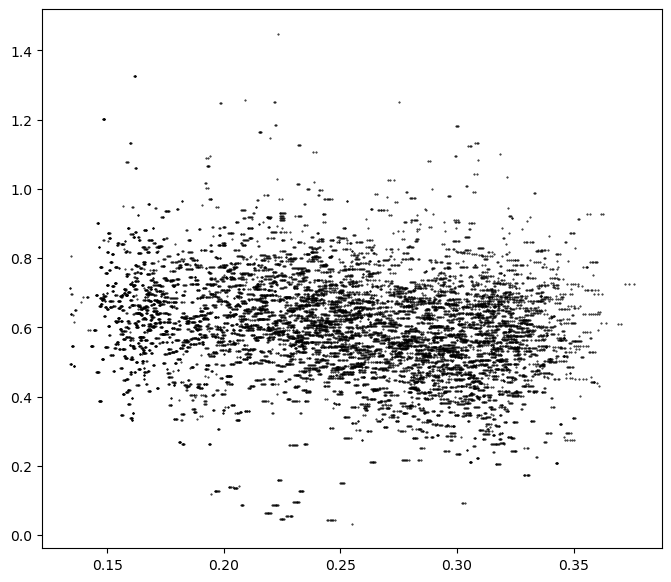

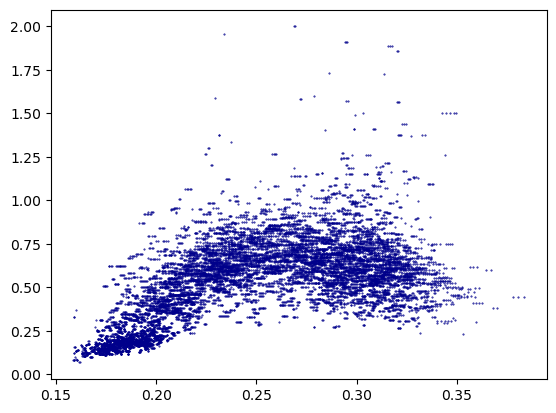

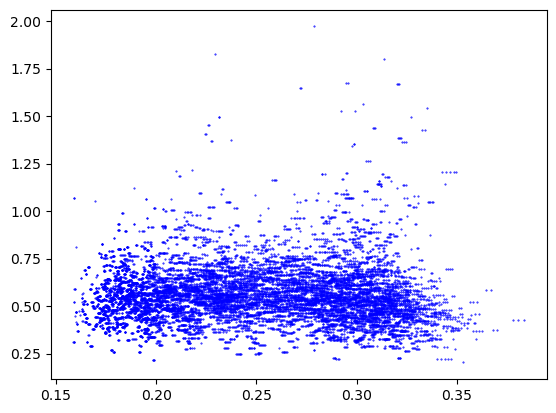

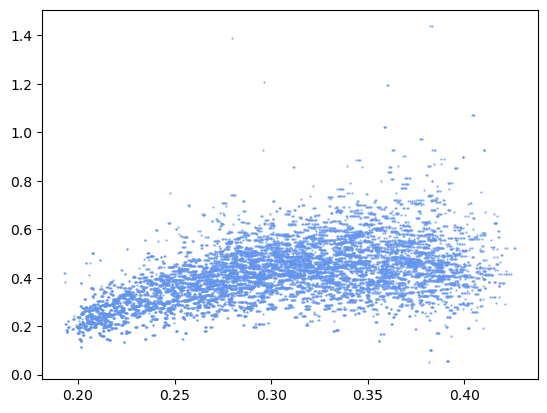

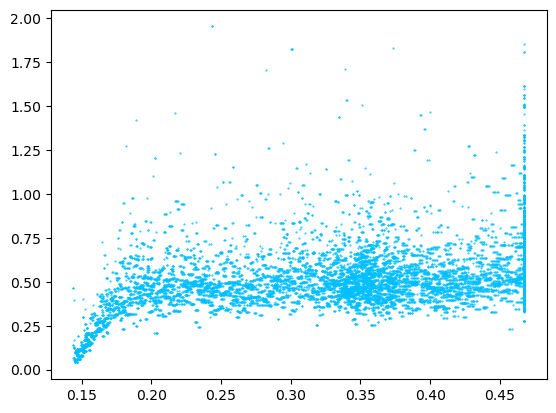

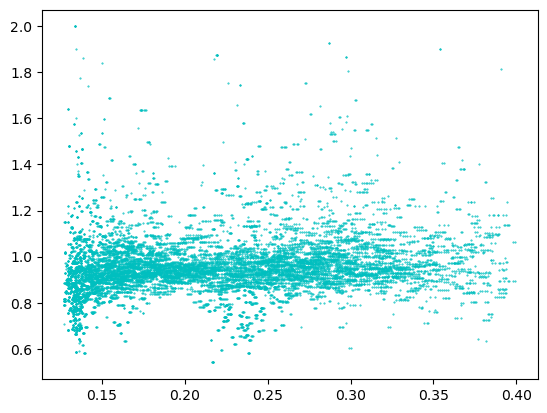

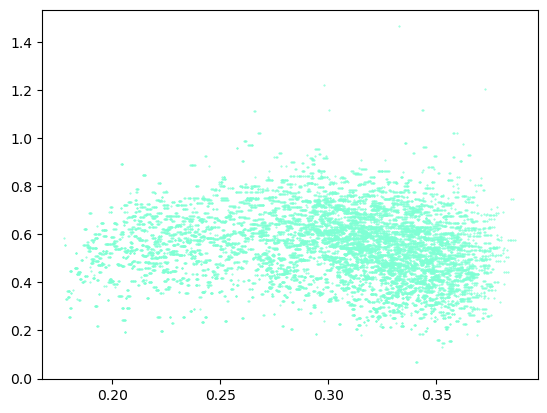

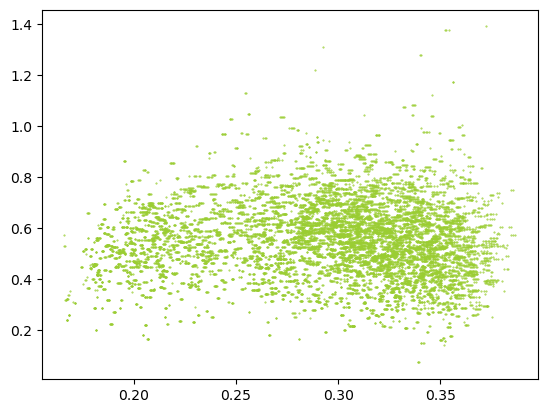

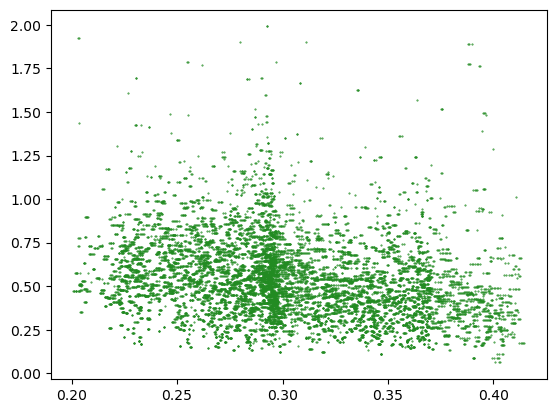

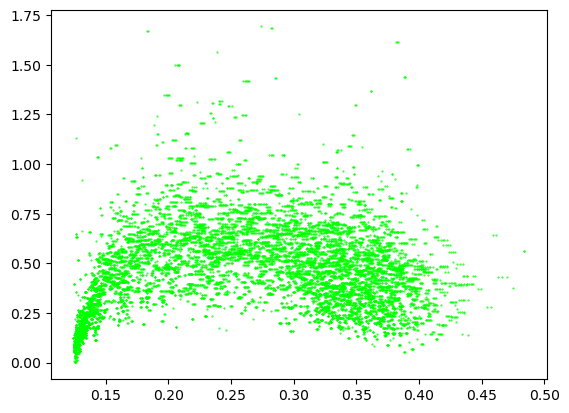

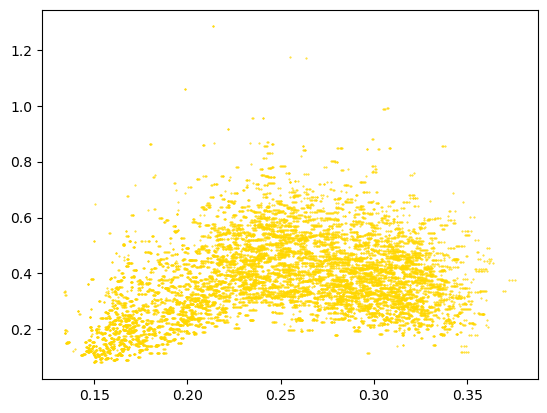

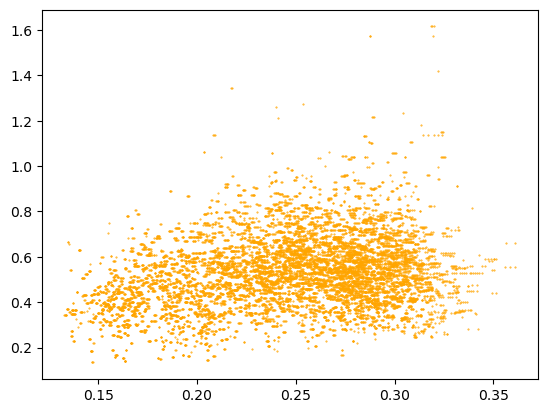

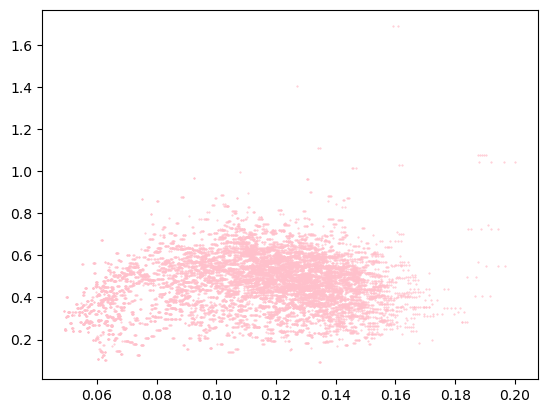

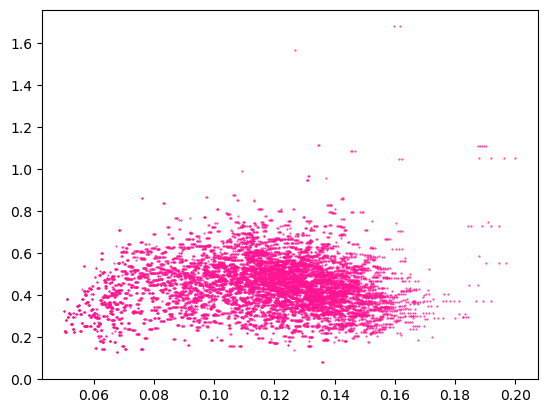

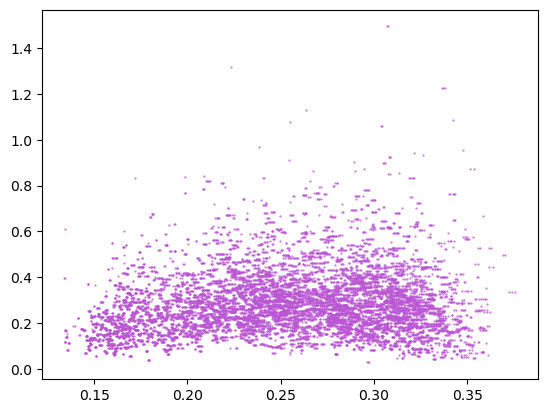

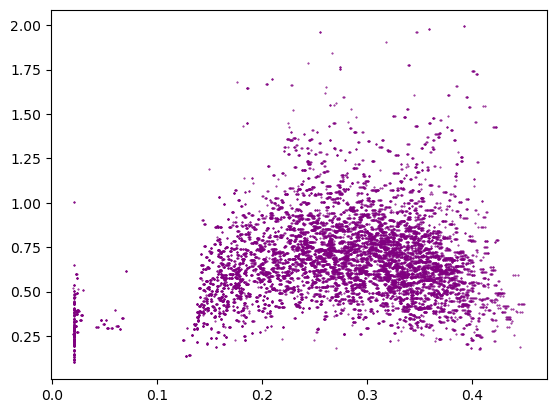

In [17]:
fig, ax    = plt.subplots(nrows=1, ncols=1, figsize=[8,7],sharex=True, sharey=False, squeeze=True)

days_after_precip = Qle_in['half_hrs_after_precip'].values/48

for model_in in model_list: 
    
    if model_in != 'obs':
        head = 'model_'
    else:
        head = ''
        
    days_10th    = np.where(SM05_per_in[head+model_in]<100, days_after_precip, np.nan)
    VPD_10th     = np.where(SM05_per_in[head+model_in]<100, Qle_in['VPD'], np.nan)
    SWdown_10th  = np.where(SM05_per_in[head+model_in]<100, Qle_in['obs_SWdown'], np.nan)
    
    Qle_10th     = np.where(SM05_per_in[head+model_in]<100, Qle_in[head+model_in], np.nan)
    EF_10th      = np.where(SM05_per_in[head+model_in]<100, EF_in[head+model_in], np.nan)
    
    try:
        LAI_10th  = np.where(SM05_per_in[head+model_in]<100, LAI_in[model_in+'_LAI'], np.nan)
    except:
        LAI_10th  = np.where(SM05_per_in[head+model_in]<100, LAI_in['obs_LAI'], np.nan)
        
    try:
        SM05_10th = np.where(SM05_per_in[head+model_in]<100, SM05_in[model_in+'_SMtop0.5m'], np.nan)
    except:
        SM05_10th = np.where(SM05_per_in[head+model_in]<100, SM05_in['model_mean_SMtop0.5m'], np.nan)
    
    SM05_per_10th = np.where(SM05_per_in[head+model_in]<100, SM05_per_in[head+model_in], np.nan)
    

    
    # plt.hist(var_to_plot, bins=bins, alpha=1., histtype='step', color=model_colors[model_in], label=model_in)

    # # Perform linear fit
    # coefficients = np.polyfit(VPD_10th, SM05_10th, 1)
    # linear_fit   = np.poly1d(coefficients)

    # ============ plot each event: ==============
#     # Generate a corresponding time array
#     time = np.arange(len(SWdown_10th))
    
#     # Find indices of non-NaN values
#     not_nan = ~np.isnan(SWdown_10th)

#     # Find the start and end indices of each continuous segment
#     segments = []
#     start_idx = None

#     for i, is_not_nan in enumerate(not_nan):
#         if is_not_nan and start_idx is None:
#             start_idx = i
#         elif not is_not_nan and start_idx is not None:
#             segments.append((start_idx, i))
#             start_idx = None

#     # Append the last segment if it ends with non-NaN
#     if start_idx is not None:
#         segments.append((start_idx, len(SWdown_10th)))

#     # Plot each segment
#     # plt.figure(figsize=(10, 6))
#     for start, end in segments:
        
#         plt.plot(VPD_10th[start:end], SM05_10th[start:end], color=model_colors[model_in], label=f'{model_in} {start}-{end}')
#         plt.legend()
#         plt.show()
    # ============================================

    var_to_plot = EF_10th
    bot_thres   = 0
    top_thres   = 2
    bins = np.linspace(bot_thres, top_thres, 100)

    var_to_plot = np.where(var_to_plot>bot_thres, var_to_plot, np.nan)
    var_to_plot = np.where(var_to_plot<top_thres, var_to_plot, np.nan)

    # Plot scatter and linear fit
    plt.scatter(SM05_10th, var_to_plot, color=model_colors[model_in], label=model_in, s=0.2)
    # plt.plot(VPD_10th, linear_fit(VPD_10th), color='red', label='Linear fit')
    plt.show()

    # ax.set_ylim(2,5)
    

In [20]:
SM05_per_in

,time,site_name,model_CABLE,model_CABLE-POP-CN,model_CHTESSEL_Ref_exp1,model_CLM5a,model_GFDL,model_JULES_GL9,model_JULES_GL9_withLAI,model_MATSIRO,model_MuSICA,model_NASAEnt,model_NoahMPv401,model_ORC2_r6593,model_ORC3_r8120,model_QUINCY,model_STEMMUS-SCOPE,obs
2174056,2002-01-02 17:00:00,AU-Tum,36.500399,36.500399,45.355635,85.527179,32.646732,33.690537,33.018195,58.892311,59.772131,45.382729,51.105122,47.863193,48.839265,45.382729,29.950947,45.382729
2174069,2002-01-03 06:00:00,AU-Tum,36.789870,36.789870,45.896076,85.527179,33.028890,33.977156,33.381816,59.057723,59.793520,45.696441,50.921173,48.540526,49.509468,45.696441,30.812942,45.696441
2174073,2002-01-03 10:00:00,AU-Tum,36.886836,36.886836,46.107118,85.527179,33.157940,34.088381,33.544376,59.111910,59.772844,45.834759,50.824920,48.731605,49.689140,45.834759,31.105265,45.834759
2174074,2002-01-03 11:00:00,AU-Tum,36.921772,36.921772,46.152749,85.527179,33.191450,34.116188,33.580025,59.126882,59.765001,45.857575,50.797827,48.775097,49.731919,45.857575,31.163016,45.857575
2174075,2002-01-03 12:00:00,AU-Tum,36.943874,36.943874,46.199806,85.527179,33.221395,34.144707,33.611396,59.137577,59.754306,45.884668,50.779289,48.820728,49.775411,45.884668,31.222194,45.884668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2314262,2017-12-31 15:00:16,AU-Tum,37.815138,37.815138,46.551306,61.693617,34.193903,34.317248,33.870209,61.173141,40.066022,45.173825,56.908795,56.786875,59.839151,45.173825,48.209702,45.173825
2314263,2017-12-31 16:00:00,AU-Tum,38.058265,38.058265,46.801563,61.780601,34.324378,34.702972,34.195329,61.271532,40.212183,45.416239,57.272416,57.518395,60.661219,45.416239,48.419319,45.416239
2314264,2017-12-31 16:59:44,AU-Tum,38.254335,38.254335,47.086756,61.864020,34.439168,35.063028,34.553245,61.377053,40.321983,45.645819,57.636037,58.259183,61.455481,45.645819,48.624658,45.645819
2314265,2017-12-31 18:00:00,AU-Tum,38.421886,38.421886,47.356263,61.927475,34.554671,35.386721,34.831308,61.451916,40.428930,45.856149,57.909822,58.880191,62.083619,45.856149,48.796486,45.856149
